# Document Question Answering (QA)

Sometimes, instead of searching for specific text patterns, you just want to ask the document a question directly. `natural-pdf` includes an extractive Question Answering feature.

"Extractive" means it finds the literal answer text within the document, rather than generating a new answer or summarizing.

Let's ask our `01-practice.pdf` a few questions.

In [1]:
#%pip install "natural-pdf[ai]"  # DocumentQA relies on torch + transformers

In [2]:
from natural_pdf import PDF

# Load the PDF and get the page
pdf = PDF("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/01-practice.pdf")
page = pdf.pages[0]

# Ask about the date
question_1 = "What is the inspection date?"
answer_1 = page.ask(question_1)

# The result dictionary always contains:
#   question    - original question
#   answer      – extracted span (string, may be empty)
#   confidence  – model score 0–1
#   start / end – indices into page.words
#   found       – False if confidence < min_confidence
answer_1

Device set to use mps


{'question': 'What is the inspection date?',
 'answer': 'February 3, 1905',
 'confidence': 0.9979940056800842,
 'start': 6,
 'end': 6,
 'found': True,
 'page_num': 0,
 'source_elements': <ElementCollection[TextElement](count=1)>}

In [3]:
page.ask("What company was inspected?")

{'question': 'What company was inspected?',
 'answer': 'Jungle Health and Safety Inspection Service',
 'confidence': 0.9988948106765747,
 'start': 0,
 'end': 0,
 'found': True,
 'page_num': 0,
 'source_elements': <ElementCollection[TextElement](count=1)>}

In [4]:
page.ask( "What is statute 5.8.3 about?")

{'question': 'What is statute 5.8.3 about?',
 'answer': 'Inadequate Protective Equipment.',
 'confidence': 0.9997999668121338,
 'start': 26,
 'end': 26,
 'found': True,
 'page_num': 0,
 'source_elements': <ElementCollection[TextElement](count=1)>}

The results include the extracted `answer`, a `confidence` score (useful for filtering uncertain answers), the `page_num`, and the `source_elements`.

## Visualising Where the Answer Came From

You can manually access results sources through `answer['source_elements']` but it's much more fun to just use `.show()`.

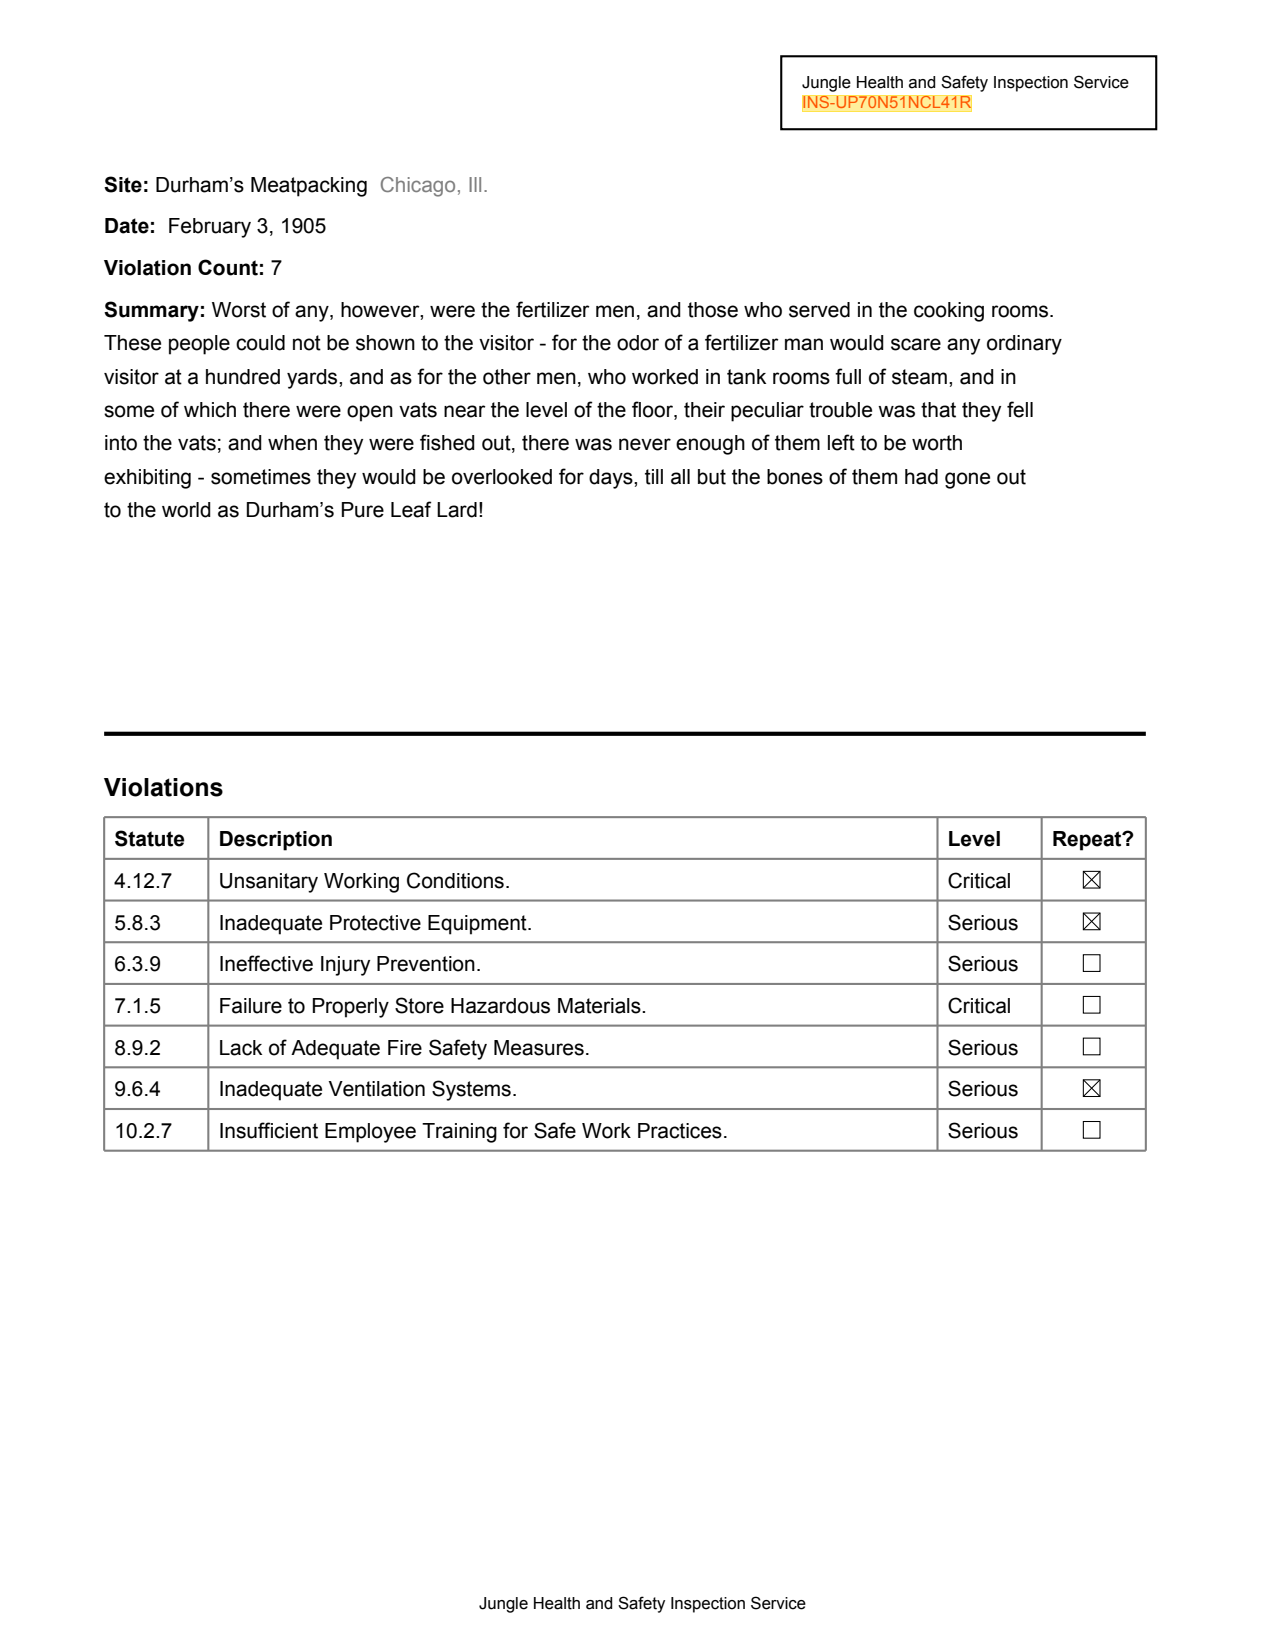

In [5]:
answer = page.ask("What is the inspection ID?")
answer.show()

## Asking an entire PDF

You don't need to select a single page to use `.ask`! It also works for entire PDFs, regions, anything.

In [6]:
pdf.ask("What company was inspected?")

{'answer': 'Jungle Health and Safety Inspection Service',
 'confidence': 0.9988948106765747,
 'found': True,
 'page_num': 1,
 'source_elements': [],
 'start': 0,
 'end': 0}

Notice that it collects the page number for later investigation.

## Collecting Results into a DataFrame

If you're asking multiple questions, it's often useful to collect the results into a pandas DataFrame. `page.ask` supports passing a **list of questions** directly. This is far faster than looping because the underlying model is invoked only once.

In [7]:
from natural_pdf import PDF
import pandas as pd

pdf = PDF("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/01-practice.pdf")
page = pdf.pages[0]

questions = [
    "What is the inspection date?",
    "What company was inspected?",
    "What is statute 5.8.3 about?",
    "How many violations were there in total?"
]

answers = page.ask(questions, min_confidence=0.2)

df = pd.json_normalize(answers)
df

,question,answer,confidence,start,end,found,page_num,source_elements
0,What is the inspection date?,"February 3, 1905",0.997994,6,6,True,0,[<TextElement text='February 3...' font='Helve...
1,What company was inspected?,Jungle Health and Safety Inspection Service,0.998895,0,0,True,0,[<TextElement text='Jungle Hea...' font='Helve...
2,What is statute 5.8.3 about?,Inadequate Protective Equipment.,0.999800,26,26,True,0,[<TextElement text='Inadequate...' font='Helve...
3,How many violations were there in total?,4.12.7,0.662560,22,22,True,0,[<TextElement text='4.12.7' font='Helvetica' s...


`pd.json_normalize` flattens the list of answer dictionaries straight into a DataFrame, making it easy to inspect the questions, their extracted answers, and associated confidence scores.

## TODO

* Demonstrate passing `model="impira/layoutlm-document-qa"` to switch models.

## QA Model and Limitations

*   The QA system relies on underlying transformer models. Performance and confidence scores vary.
*   It works best for questions where the answer is explicitly stated. It cannot synthesize information or perform calculations (e.g., counting items might fail or return text containing a number rather than the count itself).
*   You can potentially specify different QA models via the `model=` argument in `page.ask()` if others are configured.